# Networks Using Blocks (VGG)

While AlexNet proved that deep convolutional neural networks
can achieve good results, it didn't offer a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that in chip design
where engineers went from placing transistors
to logical elements to logic blocks.
Similarly, the design of neural network architectures
had grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers.

The idea of using blocks first emerged from the
[Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG)
at Oxford University.
In their eponymously-named VGG network,
It's easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.

## VGG Blocks

The basic building block of classic convolutional networks
is a sequence of the following layers:
(i) a convolutional layer
(with padding to maintain the resolution),
(ii) a nonlinearity such as a ReLu,
One VGG block consists of a sequence of convolutional layers,
followed by a max pooling layer for spatial downsampling.
In the original VGG paper `Simonyan.Zisserman.2014`,
the authors 
employed convolutions with $3\times3$ kernels
and $2 \times 2$ max pooling with stride of $2$
(halving the resolution after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.
The function takes two arguments
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.

In [1]:
import sys
sys.path.insert(0,'../')

import d2l
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    
    blk = nn.Sequential(*layers)
    
    return blk

## VGG Network

Like AlexNet and LeNet,
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and a second consisting of fully-connected layers.
The convolutional portion of the net connects several `vgg_block` modules
in succession.
Below, the variable `conv_arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments requires to call
the `vgg_block` function.
The fully-connected module is identical to that covered in AlexNet.

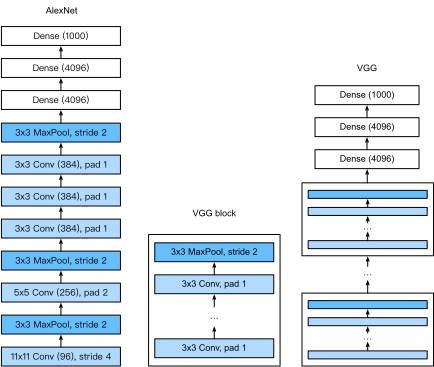

In [3]:
from IPython.display import SVG
SVG(filename="../img/vgg.svg")

Designing a network from building blocks

The original VGG network had 5 convolutional blocks,
among which the first two have one convolutional layer each
and the latter three contain two convolutional layers each.
The first block has 64 output channels
and each subsequent block doubles the number of output channels,
until that number reaches $512$.
Since this network uses $8$ convolutional layers
and $3$ fully-connected layers, it is often called VGG-11.

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for loop over `conv_arch`.

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
def vgg(conv_arch):
    # The convulational layer part
    conv_layers=[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_layers.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    net=nn.Sequential(
                      *conv_layers,
                      # The fully connected layer part
                      Flatten(),
                      nn.Linear(in_features=512*7*7, out_features=4096),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(4096, 4096),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(4096, 10)
                     )
    return net

net = vgg(conv_arch)

Next, we will construct a single-channel data example
with a height and width of 224 to observe the output shape of each layer.

In [6]:
X = torch.randn(size=(1,1,224,224), dtype=torch.float32)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As you can see, we halve height and width at each block,
finally reaching a height and width of 7
before flattening the representations
for processing by the fully-connected layer.

## Model Training

Apart from using a slightly larger learning rate,
the model training process is similar to that of AlexNet in the last section.

In [ ]:
lr, num_epochs, batch_size, device = 0.05, 5, 64, d2l.try_gpu()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
net = net.to(device)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
criterion = nn.CrossEntropyLoss()
d2l.train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr)

training on cuda:0
epoch 1, loss 0.0114, train acc 0.731, test acc 0.861, time 266.5 sec
epoch 2, loss 0.0052, train acc 0.877, test acc 0.887, time 276.4 sec
epoch 3, loss 0.0043, train acc 0.900, test acc 0.898, time 277.6 sec
epoch 4, loss 0.0037, train acc 0.912, test acc 0.909, time 276.8 sec


## Summary

* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.
* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.
* In their work Simonyan and Ziserman experimented with various architectures. In particular, they found that several layers of deep and narrow convolutions (i.e. $3 \times 3$) were more effective than fewer layers of wider convolutions.

## Exercises

1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory. Try to analyze the reasons for this.
1. Try to change the height and width of the images in Fashion-MNIST from 224 to 96. What influence does this have on the experiments?
1. Refer to Table 1 in :cite:`Simonyan.Zisserman.2014` to construct other common models, such as VGG-16 or VGG-19.